import all the necesarry library

In [1]:
import numpy as np
import pywt
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import math
from scipy.fftpack import dct
from scipy.fftpack import idct


# Functions 

Function Convert and resize image 

In [2]:
def convertImage(imageName, size,imName):
    img = Image.open(imageName).resize((size, size), 1)
    # Convert RGB image to gray scale
    img = img.convert('L')
    # Storing the gray scale image   
    if (imName != None):
        img.save('processedInputImage/' + imName)
    imageArray = np.array(img.getdata(), dtype=np.float).reshape((size, size))
    return imageArray


Function that embedded watermark image into cover image

In [3]:
# Embed watermark into the cover image
def embedWatermark(watermarkArray, originalImage):
    watermarkArraySize = len(watermarkArray[0])
    watermarkFlat = watermarkArray.ravel()
    ind = 0

    for x in range (0, len(originalImage), 8):
        for y in range (0, len(originalImage), 8):
            if ind < len(watermarkFlat):
                subdct = originalImage[x:x+8, y:y+8]
                subdct[5][5] = watermarkFlat[ind]
                originalImage[x:x+8, y:y+8] = subdct
                ind+= 1
    return originalImage

Function that apply Discrete Cosine Transform on an 8x8 block

In [4]:
# DCT transform on image, i.e. image array
def applyDCT(imageArray):
    size = len(imageArray[0])
    allSubdct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subpixels = imageArray[i:i+8, j:j+8]
            subdct = dct(dct(subpixels.T, norm="ortho").T, norm="ortho")
            allSubdct[i:i+8, j:j+8] = subdct
    return allSubdct


Function that apply Inverse Discrete Cosine Transform on an 8x8 block

In [5]:
def inverseDCT(allSubdct):
    size = len(allSubdct[0])
    allSubidct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subidct = idct(idct(allSubdct[i:i+8, j:j+8].T, norm="ortho").T, norm="ortho")
            allSubidct[i:i+8, j:j+8] = subidct

    return allSubidct


Function that extract watermark image from embedded image

In [6]:
def getWatermark(dctWatermarkedCoeff, watermarkSize):
    subwatermarks = []
    for x in range (0, len(dctWatermarkedCoeff), 8):
        for y in range (0, len(dctWatermarkedCoeff), 8):
            coeffSlice = dctWatermarkedCoeff[x:x+8, y:y+8]
            subwatermarks.append(coeffSlice[5][5])
    watermark = np.array(subwatermarks).reshape(watermarkSize, watermarkSize)
    return watermark

Function that recover watermark image using 2 key

In [7]:
def recoverWatermark(image):
    coeffsWatermarkedImage=list(pywt.wavedec2(data = image, wavelet = 'haar', level = 1))
    dctWatermarkedCoeff = applyDCT(coeffsWatermarkedImage[0])
    watermarkArray = getWatermark(dctWatermarkedCoeff, 128)
    watermarkArray =  np.uint8(watermarkArray)
    #Save result
    img = Image.fromarray(watermarkArray)
    img.save('result/recoveredWatermark.png')

Function for save image

In [8]:
def printImage(imageArray, name):
    imageArrayCopy = imageArray.clip(0, 255)
    imageArrayCopy = imageArrayCopy.astype("uint8")
    img = Image.fromarray(imageArrayCopy)
    img.save('result/' + name)

Function that embedded watermark image into cover
image

In [9]:
def embeddedImage(coverImage, watermarkImage):

    fileName, fileType = coverImage.split(".")
    imageArray = convertImage(coverImage, 2048, "1."+fileType)
    watermarkArray = convertImage(watermarkImage, 128, "2."+fileType)

    coeffsImage = list(pywt.wavedec2(data=imageArray, wavelet = 'haar', level = 1))
    
    dctArray = applyDCT(coeffsImage[0])
    dctArray = embedWatermark(watermarkArray, dctArray)

    coeffsImage[0] = inverseDCT(dctArray)

    imageArrayH=pywt.waverec2(coeffsImage, 'haar')
    

    printImage(imageArrayH, fileName+'_watermarkedImage.'+fileType)
    return imageArrayH

# Testing

In [10]:
watermarkeImage = embeddedImage("lena.png","logo.png",key = 0)

In [11]:
recoverWatermark(watermarkeImage,key = 0)

# Plot all three resultant image

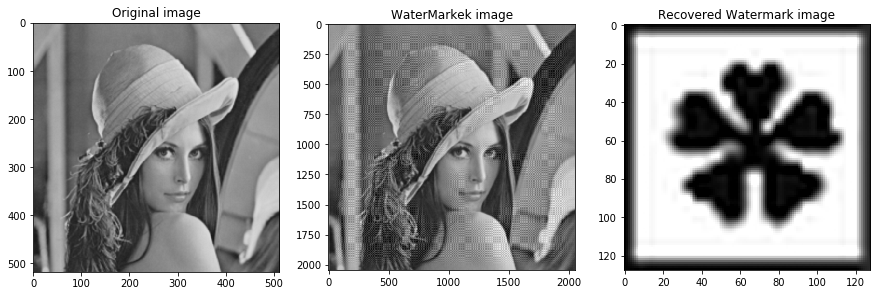

In [105]:
import matplotlib.pyplot as plt
import cv2

image = cv2.imread("lena.png")
waterimg = cv2.imread("result/lena_watermarkedImage.png")
recovwater = cv2.imread("result/recoveredWatermark.png")

plt.figure(figsize = (15,15))
plt.subplot(1,3,1),plt.imshow(image),plt.title("Original image")
plt.subplot(1,3,2),plt.imshow(waterimg),plt.title("WaterMarkek image")
plt.subplot(1,3,3),plt.imshow(recovwater),plt.title("Recovered Watermark image")
plt.show()

# Calculate PSNR value

In [14]:
def pastingImage (img1, img2):
    temp = img2.copy()
    x_offset=y_offset=50
    img2[y_offset:y_offset+img1.shape[0], x_offset:x_offset+img1.shape[1]] = img1
    
    return img2, temp

In [15]:
def compute_psnr(img1, img2):
    
    img1 = img1.astype(np.float64) / 255.
    img2 = img2.astype(np.float64) / 255.
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return "Same Image"
    return 10 * math.log10(1. / mse)

In [18]:
def NCC(img1, img2):
    return abs(np.mean(np.multiply((img1-np.mean(img1)),(img2-np.mean(img2))))/(np.std(img1)*np.std(img2)))

In [16]:
img1 = cv2.imread("lena.png")
img2 = cv2.imread("result/lena_watermarkedImage.png")
img1, img2 = pastingImage(img1,img2)

psnr = compute_psnr(img1, img2)
print (f'PSNR value of resultant image is {psnr}')

PSNR value of resultant image is 24.303297579683175


In [19]:
print (f'Normalized cross correlation is {NCC(img1, img2)}')

Normalized cross correlation is 0.9489480047214953


# Attacks (Geometric & Signal Processing)

In [205]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col= image.shape
        mean = 0
        var = 0.001
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col))
        gauss = gauss.reshape(row,col)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col = image.shape
        s_vs_p = 0.5
        amount = 0.01
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col = image.shape
        gauss = np.random.randn(row,col)
        gauss = gauss.reshape(row,col)        
        noisy = image + image * gauss
        return noisy
    elif noise_typ == "rotate90" :
        angle = 90
        scale = 1.0
        w = image.shape[1]
        h = image.shape[0]
        rangle = np.deg2rad(angle)  # angle in radians
        nw = (abs(np.sin(rangle) * h) + abs(np.cos(rangle) * w)) * scale
        nh = (abs(np.cos(rangle) * h) + abs(np.sin(rangle) * w)) * scale
        rot_mat = cv2.getRotationMatrix2D((nw * 0.5, nh * 0.5), angle, scale)
        rot_move = np.dot(rot_mat, np.array(
            [(nw - w) * 0.5, (nh - h) * 0.5, 0]))
        rot_mat[0, 2] += rot_move[0]
        rot_mat[1, 2] += rot_move[1]
        noisy=cv2.warpAffine(image, rot_mat, (int(math.ceil(nw)), int(math.ceil(nh))), flags=cv2.INTER_LANCZOS4)
        return noisy
    elif noise_typ=="chop30":
        img = image.copy()
        w, h = img.shape[:2]
        noisy=img[int(w * 0.3):, :]
        return noisy


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
				 Geometric Attacks
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


				 Rotate 90º
-----------------------------------------------------------------------------------------


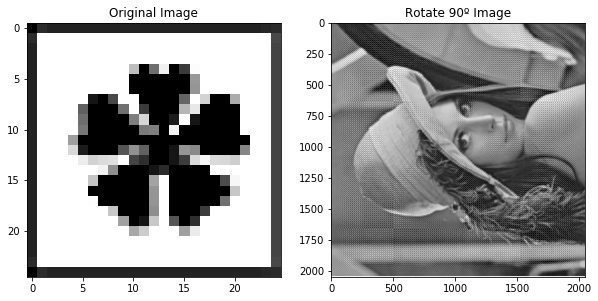

			 Normalized cross correlation is  0.9997765302806157
******************************************************************************************
				 Chop 30
-----------------------------------------------------------------------------------------


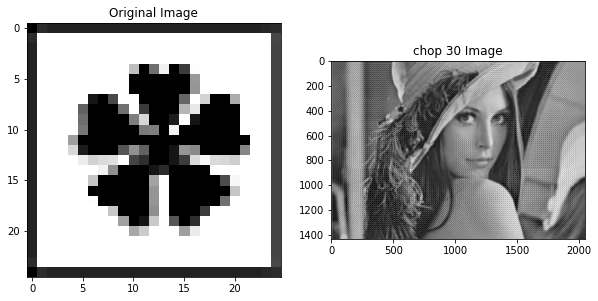

			 Normalized cross correlation is  0.9996272697891584
******************************************************************************************
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
				 Image Filtering Attacks
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


				 Gaussian Noise 
-----------------------------------------------------------------------------------------


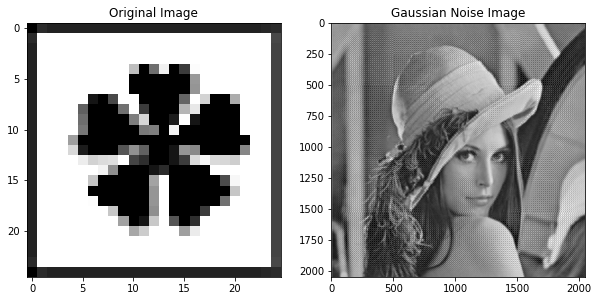

			 Normalized cross correlation is  0.9997941969826453
******************************************************************************************
				 Salt and Pepper Noise
-----------------------------------------------------------------------------------------


C:\Users\voilentKiller0\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\voilentKiller0\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


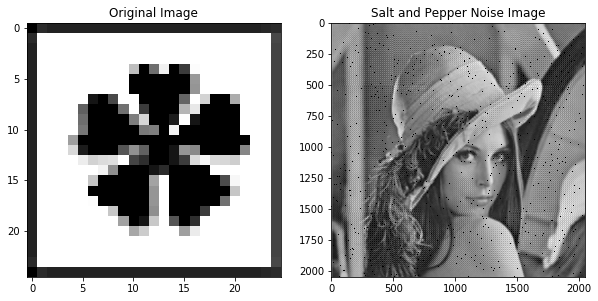

			 Normalized cross correlation is  0.9998003998834198
******************************************************************************************
				 Poisson Noise
-----------------------------------------------------------------------------------------


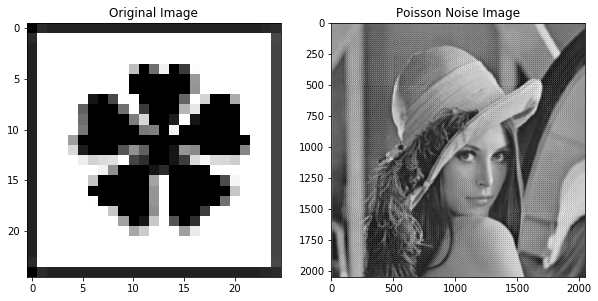

			 Normalized cross correlation is  0.9997942733024805
******************************************************************************************
				 Speckle Noise
-----------------------------------------------------------------------------------------


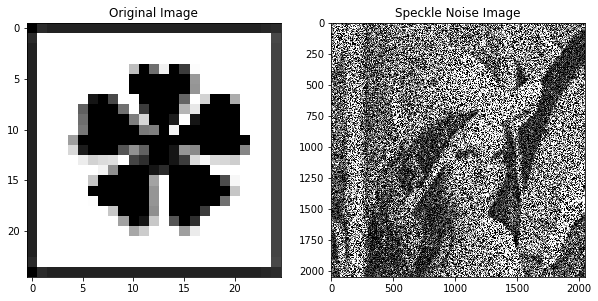

			 Normalized cross correlation is  0.999929251735013
******************************************************************************************


In [212]:
originalImage = cv2.imread("logo.png", cv2.IMREAD_GRAYSCALE)
embeddedImage = cv2.imread("result/lena_watermarkedImage.png", cv2.IMREAD_GRAYSCALE)


print ('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print ('\t\t\t\t Geometric Attacks')
print ('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n\n')

print ("\t\t\t\t Rotate 90º")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "rotate90",embeddedImage)
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(originalImage, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Original Image")
plt.subplot(1,2,2), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Rotate 90º Image")
plt.show()
print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage,img),img))
print ("******************************************************************************************")
print ("\t\t\t\t Chop 30")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "chop30",embeddedImage)
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(originalImage, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Original Image")
plt.subplot(1,2,2), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("chop 30 Image")
plt.show()
print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage,img),img))
print ("******************************************************************************************")

print ('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print ('\t\t\t\t Image Filtering Attacks')
print ('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n\n')

print ("\t\t\t\t Gaussian Noise ")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "gauss",embeddedImage)
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(originalImage, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Original Image")
plt.subplot(1,2,2), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Gaussian Noise Image")
plt.show()
print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage,img),img))
print ("******************************************************************************************")

print ("\t\t\t\t Salt and Pepper Noise")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "s&p",embeddedImage)
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(originalImage, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Original Image")
plt.subplot(1,2,2), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Salt and Pepper Noise Image")
plt.show()
print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage,img),img))
print ("******************************************************************************************")

print ("\t\t\t\t Poisson Noise")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "poisson",embeddedImage)
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(originalImage, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Original Image")
plt.subplot(1,2,2), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Poisson Noise Image")
plt.show()
print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage, img), img))
print ("******************************************************************************************")

print ("\t\t\t\t Speckle Noise")
print ("-----------------------------------------------------------------------------------------")
img = noisy( "speckle",embeddedImage)
plt.figure(figsize = (10,10))
plt.subplot(1,2,1), plt.imshow(originalImage, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Original Image")
plt.subplot(1,2,2), plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255), plt.title("Speckle Noise Image")
plt.show()
print ("\t\t\t Normalized cross correlation is ", NCC(pastingImage(originalImage, img), img))
print ("******************************************************************************************")